In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('/home/helfrech/Tools/GCH/GCH')

# Maths
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# Plotting
import matplotlib.pyplot as plt

# Atoms
import ase.io as aseio

# ML
from regression import KPCovR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast
from gch_init import gch_init
from gch_run import gch_run

# Utilities
import h5py
import json
import subprocess
import glob
from project_utils import load_structures_from_hdf5

# SOAP
from soap import quippy_soap, librascal_soap

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
#sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
#from utilities.sklearn_covr.kpcovr import KernelPCovR as KPCovR2

# Build the GCH

In [4]:
gch_dir = './gchtmp'

In [5]:
cutoff = 6.0

In [6]:
component_idxs = np.loadtxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_components.idxs', 
                            usecols=0, dtype=np.int)

In [7]:
# Load SOAP hyperparameters
# TODO: load from hyperparamters file
centers = [14] # Center on Si, take Si and O in environment
n = 12
l = 9

soap_args = dict(max_radial=n,
                 max_angular=l,
                 interaction_cutoff=6.0, 
                 cutoff_smooth_width=0.3, 
                 gaussian_sigma_constant=0.3, 
                 component_idxs=component_idxs)

In [8]:
# Load kernel hyperparamters
model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'

with open(model_file, 'r') as f:
    model_dict = json.load(f)

kernel_type = model_dict['kernel_type']
gamma = model_dict['gamma']

In [9]:
# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)
deem_soaps = deem_soaps[0::100]

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)

In [10]:
# Build kernel
K = build_kernel(iza_soaps+deem_soaps, iza_soaps+deem_soaps,
                 kernel=kernel_type, gamma=gamma)

np.savetxt(f'{gch_dir}/K.dat', K)

100%|██████████| 326/326 [00:52<00:00,  6.24it/s]


In [11]:
# Concatenate IZA and DEEM xyz files
deem = aseio.read('../Raw_Data/GULP/DEEM_10k/DEEM_10000_OPT.xyz', index=':')
iza = aseio.read('../Raw_Data/GULP/IZA_226/IZA_OPT.xyz', index=':')
aseio.write(f'{gch_dir}/iza+deem.xyz', iza+deem[0::100], format='extxyz')

# Prepare energies
energies = []
for i in iza:
    energies.append(i.info['Energy_per_Si'])

energy_errors = []
for d in deem[0::100]:
    energies.append(d.info['Energy_per_Si'])
    energy_errors.append(d.info['Energy_per_Si'] - d.info['Energy_per_Si_Opt'])
    
energies = np.asarray(energies)
energies -= np.mean(energies, axis=0)
energy_errors = np.asarray(energy_errors)
energy_rmse = np.sqrt(np.mean(energy_errors**2))

np.savetxt(f'{gch_dir}/energies_per_si.dat', energies)

In [41]:
print(energy_rmse)

0.3578976890827528


In [12]:
# Compute cell uncertainty
orig_glob = sorted(glob.glob('../Raw_Data/GULP/IZA_226/Orig_cif_files.d/*.cif'))
opt_glob = sorted(glob.glob('../Raw_Data/GULP/IZA_226/Opt_cif_files.d/*.cif'))

cell_errors = []
for orig, opt in zip(orig_glob, opt_glob):
    orig_cif = aseio.read(orig)
    opt_cif = aseio.read(opt)
    cell_errors.append(np.linalg.norm(orig_cif.cell - opt_cif.cell)**2)
    
cell_errors = np.asarray(cell_errors)
cell_rmse = np.sqrt(np.mean(cell_errors))

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(74, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'triclinic' is not interpreted for space group 1. This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'cubic' is not interpreted for space group Spacegroup(229, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(63, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMEN

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(127, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'monoclinic' is not interpreted for space group Spacegroup(10, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(38, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(65, setting=1). This may result in wrong setting!
  setting_name, spacegro

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(66, setting=1). This may result in wrong setting!
  setting_name, spacegroup))


In [40]:
print(cell_rmse)

0.31616550738291077


In [13]:
# Initialize GCH
pk = f'{gch_dir}/K.dat' # File containing the kernel
pnrg = f'{gch_dir}/energies_per_si.dat' # File containing the energies
setxyz = f'{gch_dir}/iza+deem.xyz' # File containing the structures
wdir_local = f'{gch_dir}/rattled' # Directory in which to save the rattled reference structures
s_c = cell_rmse # Uncertainty in cell between structures
s_e = energy_rmse # Uncertainty in energy
ndim = 3 # GCH dimensions (includes energy)
numref = 10 # Number of reference structures
numshaken = 5 # Number of rattled structures per reference
conv = 0.20 # Convergence threshold: 100/conv hulls are constructed
mode = 'fps' # Selection mode for the reference structures
npca = -1 # Number of KPCA components: None for providing projections, <= 0 for taking all components

gch_init(pk, pnrg, setxyz, wdir_local, s_c, s_e, ndim, numref, numshaken, conv, mode, npca)

Loading the kernel matrix, it can take a minute if thousands of elements
/scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/./gchtmp/rattled
DONE: Loaded data
Initializing statistical sampling of the fuzzy GCH
Uncertainty in Cartesian positions 0.8731030309980917
DONE ! go to /scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/./gchtmp/rattled/ to see what's in there


In [14]:
# Compute SOAPs for shaken structures
shaken_refs = aseio.read(f'{gch_dir}/rattled/shaketraj.xyz', index=':')

shaken_ref_soaps = librascal_soap(shaken_refs, centers, **soap_args)

100%|██████████| 60/60 [00:01<00:00, 51.45it/s]


In [15]:
# Compute kernel for shaken structures
K_rattled = build_kernel(shaken_ref_soaps, iza_soaps+deem_soaps,
                 kernel=kernel_type, gamma=gamma)
np.savetxt(f'{gch_dir}/rattled/K.dat', K_rattled)

100%|██████████| 60/60 [00:07<00:00,  7.63it/s]


In [16]:
# Run GCH
shk = f'{gch_dir}/rattled/K.dat' # File containing the kernel for the rattled structures
wdir = f'{gch_dir}/rattled' # Directory in which the rattled reference structures reside
mp = 0.51 # Cutoff probability for determining the GCH vertices
gch_run(shk, wdir, mp)

We will load both the dataset kernel and the shaken kernel, it could take some minutes in case of thousands of structures..
Centering!
  And now we build a projection 
Done, super quick. 
You have selected 500 convex hulls samples per pruning iterations
Statistical sampling of the fuzzy GCH
GCH construction :  0.11388134956359863  sec
Single Hull construction during before pruning :  0.06244540214538574  sec
Iteration :  200  in  500
Iteration :  400  in  500
 Let's start pruning! 
printing rr_pfile.shape
(50, 327)
Iteration :  200  in  500
Iteration :  400  in  500
0.086
Pruning iter :  1  min prob:  0.086  # vertex :  50
printing rr_pfile.shape
(43, 327)
Iteration :  200  in  500
Iteration :  400  in  500
0.142
Pruning iter :  2  min prob:  0.142  # vertex :  43
printing rr_pfile.shape
(37, 327)
Iteration :  200  in  500
Iteration :  400  in  500
0.202
Pruning iter :  3  min prob:  0.202  # vertex :  37
printing rr_pfile.shape
(33, 327)
Iteration :  200  in  500
Iteration :  400  in 

In [17]:
vprobprune = np.loadtxt(f'{gch_dir}/rattled/vprobprune.dat')
vprobprune.shape

(9, 326)

# Build a GCH based on KPCovR projections (just and example using the energy as the property)

In [50]:
gch_dir = './gchtmp_kpcovr'

In [51]:
cutoff = 6.0

In [52]:
component_idxs = np.loadtxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_components.idxs', 
                            usecols=0, dtype=np.int)

In [53]:
# Load SOAP hyperparameters
# TODO: load from hyperparamters file
centers = [14] # Center on Si, take Si and O in environment
n = 12
l = 9

soap_args = dict(max_radial=n,
                 max_angular=l,
                 interaction_cutoff=6.0, 
                 cutoff_smooth_width=0.3, 
                 gaussian_sigma_constant=0.3, 
                 component_idxs=component_idxs)

In [54]:
# Load kernel hyperparamters
model_file = f'../Processed_Data/Models/{cutoff}/volumes_mae_parameters.json'

with open(model_file, 'r') as f:
    model_dict = json.load(f)

kernel_type = model_dict['kernel_type']
gamma = model_dict['gamma']

In [55]:
# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)
deem_soaps = deem_soaps[0::100]

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)

In [56]:
# Build kernel
K = build_kernel(iza_soaps+deem_soaps, iza_soaps+deem_soaps,
                 kernel=kernel_type, gamma=gamma)

np.savetxt(f'{gch_dir}/K.dat', K)

100%|██████████| 326/326 [00:52<00:00,  6.17it/s]


In [57]:
# Concatenate IZA and DEEM xyz files
deem = aseio.read('../Raw_Data/GULP/DEEM_10k/DEEM_10000_OPT.xyz', index=':')
iza = aseio.read('../Raw_Data/GULP/IZA_226/IZA_OPT.xyz', index=':')
aseio.write(f'{gch_dir}/iza+deem.xyz', iza+deem[0::100], format='extxyz')

# Prepare energies
energies = []
for i in iza:
    energies.append(i.info['Energy_per_Si'])

energy_errors = []
for d in deem[0::100]:
    energies.append(d.info['Energy_per_Si'])
    energy_errors.append(d.info['Energy_per_Si'] - d.info['Energy_per_Si_Opt'])
    
energies = np.asarray(energies)
energies -= np.mean(energies, axis=0)
energy_errors = np.asarray(energy_errors)
energy_rmse = np.sqrt(np.mean(energy_errors**2))

np.savetxt(f'{gch_dir}/energies_per_si.dat', energies)

In [58]:
print(energy_rmse)

0.3578976890827528


In [59]:
# Compute cell uncertainty
orig_glob = sorted(glob.glob('../Raw_Data/GULP/IZA_226/Orig_cif_files.d/*.cif'))
opt_glob = sorted(glob.glob('../Raw_Data/GULP/IZA_226/Opt_cif_files.d/*.cif'))

cell_errors = []
for orig, opt in zip(orig_glob, opt_glob):
    orig_cif = aseio.read(orig)
    opt_cif = aseio.read(opt)
    cell_errors.append(np.linalg.norm(orig_cif.cell - opt_cif.cell)**2)
    
cell_errors = np.asarray(cell_errors)
cell_rmse = np.sqrt(np.mean(cell_errors))

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(74, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'triclinic' is not interpreted for space group 1. This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'cubic' is not interpreted for space group Spacegroup(229, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(63, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMEN

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(58, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(127, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'monoclinic' is not interpreted for space group Spacegroup(10, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(38, setting=1). This may result in wrong setting!
  setting_name, spacegro

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(66, setting=1). This may result in wrong setting!
  setting_name, spacegroup))


In [60]:
print(cell_rmse)

0.31616550738291077


In [61]:
# Center kernels
Kc = center_kernel_fast(K)

In [62]:
kpcovr = KPCovR(alpha=0.1, n_kpca=None, reg=1.0E-12, reg_type='scalar', tiny=1.0E-15, rcond=None)
kpcovr.fit(Kc, energies)
T = kpcovr.transform_K(Kc)

# # Seems unstable...
# kpcovr = KPCovR2(mixing=0.5, n_components=Kc.shape[0], kernel='precomputed', 
#                  krr_params=dict(alpha=1.0E-12))
# kpcovr.fit(Kc, energies)
# T = kpcovr.transform(Kc)

np.savetxt(f'{gch_dir}/T.dat', T)

In [63]:
# Initialize GCH
pk = f'{gch_dir}/T.dat' # File containing the kernel
pnrg = f'{gch_dir}/energies_per_si.dat' # File containing the energies
setxyz = f'{gch_dir}/iza+deem.xyz' # File containing the structures
wdir_local = f'{gch_dir}/rattled' # Directory in which to save the rattled reference structures
s_c = cell_rmse # Uncertainty in cell between structures
s_e = energy_rmse # Uncertainty in energy
ndim = 3 # GCH dimensions (includes energy)
numref = 10 # Number of reference structures
numshaken = 5 # Number of rattled structures per reference
conv = 0.20 # Convergence threshold: 100/conv hulls are constructed
mode = 'fps' # Selection mode for the reference structures
npca = None # Number of KPCA components: None for providing projections, <= 0 for taking all components

gch_init(pk, pnrg, setxyz, wdir_local, s_c, s_e, ndim, numref, numshaken, conv, mode, npca)

Loading the kernel matrix, it can take a minute if thousands of elements
/scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/./gchtmp_kpcovr/rattled
DONE: Loaded data
Initializing statistical sampling of the fuzzy GCH
Uncertainty in Cartesian positions 0.8847057325839279
DONE ! go to /scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/./gchtmp_kpcovr/rattled/ to see what's in there


In [64]:
# Compute SOAPs for shaken structures
shaken_refs = aseio.read(f'{gch_dir}/rattled/shaketraj.xyz', index=':')

shaken_ref_soaps = librascal_soap(shaken_refs, centers, **soap_args)

100%|██████████| 60/60 [00:02<00:00, 26.47it/s]


In [65]:
# Compute kernel for shaken structures
K_rattled = build_kernel(shaken_ref_soaps, iza_soaps+deem_soaps,
                 kernel=kernel_type, gamma=gamma)
Kc_rattled = center_kernel_fast(K_rattled, K_ref=K)

100%|██████████| 60/60 [00:08<00:00,  6.68it/s]


In [66]:
T_rattled = kpcovr.transform_K(Kc_rattled)
np.savetxt(f'{gch_dir}/rattled/T.dat', T_rattled)

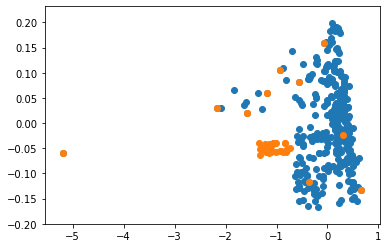

In [67]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T_rattled[:, 0], T_rattled[:, 1])
plt.show()

In [68]:
# Run GCH
shk = f'{gch_dir}/rattled/T.dat' # File containing the kernel for the rattled structures
wdir = f'{gch_dir}/rattled' # Directory in which the rattled reference structures reside
mp = 0.51 # Cutoff probability for determining the GCH vertices
gch_run(shk, wdir, mp)

We will load both the dataset kernel and the shaken kernel, it could take some minutes in case of thousands of structures..
You have selected 500 convex hulls samples per pruning iterations
Statistical sampling of the fuzzy GCH
GCH construction :  0.06535696983337402  sec
Single Hull construction during before pruning :  0.06377553939819336  sec
Iteration :  200  in  500
Iteration :  400  in  500
 Let's start pruning! 
printing rr_pfile.shape
(189, 326)
Iteration :  200  in  500
Iteration :  400  in  500
0.004
Pruning iter :  1  min prob:  0.004  # vertex :  189
printing rr_pfile.shape
(128, 326)
Iteration :  200  in  500
Iteration :  400  in  500
0.012
Pruning iter :  2  min prob:  0.012  # vertex :  128
printing rr_pfile.shape
(94, 326)
Iteration :  200  in  500
Iteration :  400  in  500
0.034
Pruning iter :  3  min prob:  0.034  # vertex :  94
printing rr_pfile.shape
(72, 326)
Iteration :  200  in  500
Iteration :  400  in  500
0.052
Pruning iter :  4  min prob:  0.052  # vertex :  

In [69]:
vprobprune = np.loadtxt(f'{gch_dir}/rattled/vprobprune.dat')
print(vprobprune.shape)

(14, 326)


[  3  46  73  76 122 131 136 153 157 169 170 189 218 224 241 279 303]


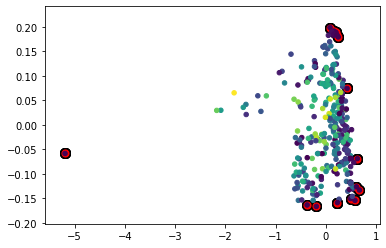

In [70]:
# Hull distances
gch_vertices = np.nonzero(vprobprune[-1])[0]
print(gch_vertices)
e_gch = energies[gch_vertices]
T_gch = T[gch_vertices, :]

eT = np.hstack((e_gch[:, np.newaxis], T_gch))
eT_all = np.hstack((energies[:, np.newaxis], T))
vertex_hull = ConvexHull(eT[:, 0:ndim])

d = np.matmul(eT_all[:, 0:ndim], vertex_hull.equations[:, 0:-1].T) + vertex_hull.equations[:, -1]
de = d / vertex_hull.equations[:, 0]
d = np.amin(np.abs(d), axis=1)
de = np.amin(np.abs(de), axis=1)

for vertex_simplex in vertex_hull.simplices:
    plt.scatter(T_gch[vertex_simplex, 0], T_gch[vertex_simplex, 1], c='k', s=100)
    
plt.scatter(T_gch[vertex_hull.vertices,0], T_gch[vertex_hull.vertices,1], c='r', s=50)
plt.scatter(T[:,0], T[:,1], c=d, cmap='viridis', s=20)
plt.show()

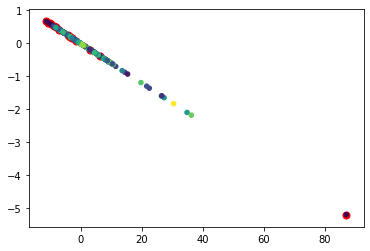

In [71]:
plt.scatter(eT_all[gch_vertices, 0], eT_all[gch_vertices, 1], c='r', s=50)
plt.scatter(eT_all[:,0], eT_all[:,1], c=de, cmap='viridis', s=20)
plt.show()

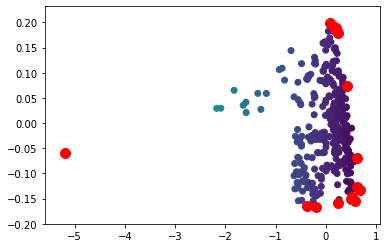

In [72]:
plt.scatter(T[:, 0], T[:, 1], c=energies, cmap='viridis')
plt.scatter(T[gch_vertices, 0], T[gch_vertices, 1], c='r', s=100)
plt.show()